# Finetuning a pretrained transformer model for citing sentence classification

A citing sentence contains references to other works as proof, acknowledgement,comparison, etc. This notebook attempts to train a model to automatically identify such sentences by finetuning an already existing model on a large dataset of labeled sentences extracted from papers.

## Dataset

The dataset used is constructed using [this](http://www.citation-recommendation.org/publications/) dataset of sentences from scientific papers as a base. These contain reference markers and other metadata for citations, I used them to automatically label sentences.

It can be downloaded from [here](https://drive.google.com/drive/folders/1lI9OED8Bif_NG9SaETitlDqkfU-gZsrz?usp=sharing).


## Model
The final finetuned model can be downloaded from [here](https://drive.google.com/drive/folders/1ZfQt04w8pxYFsq8VgP6YBP9tMQ3nBv8r?usp=sharing) and loaded using the transfomers library or directly with pytorch.




# Downloads

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install transformers library.
!pip install -q git+https://github.com/huggingface/transformers.git
# Install helper functions.
!pip install -q git+https://github.com/gmihaila/ml_things.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.8 MB/s eta 0:00:00


# Imports

In [ ]:
import io
import os
import torch
import pandas as pd
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (AutoConfig,
                          AutoModelForSequenceClassification,
                          AutoTokenizer, AdamW,
                          get_linear_schedule_with_warmup,
                          set_seed,
                          )


# Set seed for reproducibility,
set_seed(123)

epochs = 1
batch_size = 64
max_length = 512

# Look for gpu to use. Will use `cpu` by default if no gpu found.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Name of transformers model - will use already pretrained model.
model_name_or_path = 'allenai/scibert_scivocab_uncased'

# Dicitonary of labels and their id - this will be used to convert.
# String labels to number.
labels_ids = {False: 0, True: 1}

# How many labels are we using in training.
# This is used to decide size of classification head.
n_labels = len(labels_ids)

## Dataset and training loop

The dataset is loaded using a custom `Dataset` class, entries are tokenized on demand. A `DataLoader` will be used to batch entries from the dataset efficiently.

Note: only 20% of the dataset is used due to its less than ideal size (taking over 15 hours to train a single epoch on an A100).

The training loop is fairly standard and represents a full pass through the dataset.

In [ ]:
class PaperSentencesDataset(Dataset):
    def __init__(self, path, use_tokenizer, max_sequence_len=None):
        if not os.path.isfile(path):
            raise ValueError('Invalid `path` variable! Needs to be a file')

        self.use_tokenizer = use_tokenizer
        self.max_sequence_len = max_sequence_len or use_tokenizer.model_max_length

        df = pd.read_parquet(path, engine="pyarrow")
        # drop na
        df = df.dropna()
        # use 20% of dataset
        df = df.sample(frac=0.2)
        self.texts = df['sentence'].tolist()
        self.labels = torch.tensor(df['citing'].tolist(), dtype=torch.long)

        self.n_examples = len(self.labels)

    def __len__(self):
        return self.n_examples

    def __getitem__(self, idx):
        encoding = self.use_tokenizer(
            self.texts[idx],
            add_special_tokens=True,
            truncation=True,
            padding="max_length",
            return_tensors='pt',
            max_length=self.max_sequence_len
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": self.labels[idx]
        }


def collate_fn(batch):
    input_ids = torch.stack([item["input_ids"] for item in batch])
    attention_mask = torch.stack([item["attention_mask"] for item in batch])
    labels = torch.stack([item["labels"] for item in batch])

    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}


def train(dataloader, optimizer_, scheduler_, device_):
    global model
    model.train()
    predictions_labels = []
    true_labels = []
    total_loss = 0

    scaler = torch.cuda.amp.GradScaler()  # Enable mixed precision training

    for batch in tqdm(dataloader, total=len(dataloader)):
        true_labels += batch['labels'].cpu().numpy().flatten().tolist()
        batch = {k: v.to(device_) for k, v in batch.items()}

        optimizer_.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(**batch)
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer_)
        scaler.update()
        scheduler_.step()

        total_loss += loss.item()
        logits = outputs.logits.detach().cpu().numpy()
        predictions_labels += logits.argmax(axis=-1).flatten().tolist()

    avg_epoch_loss = total_loss / len(dataloader)
    return true_labels, predictions_labels, avg_epoch_loss


def validation(dataloader, device_):
    global model
    model.eval()
    predictions_labels = []
    true_labels = []
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, total=len(dataloader)):
            true_labels += batch['labels'].cpu().numpy().flatten().tolist()
            batch = {k: v.to(device_) for k, v in batch.items()}

            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item()
            logits = outputs.logits.detach().cpu().numpy()
            predictions_labels += logits.argmax(axis=-1).flatten().tolist()

    avg_epoch_loss = total_loss / len(dataloader)
    return true_labels, predictions_labels, avg_epoch_loss

# Load Model and Tokenizer

The model used as a base is SciBERT, a version of BERT finetuned on scientific text, meaning that its vocabulary (or more specifically, its tokens) should include common terms in most scientific fields, improving the results.

In [ ]:
# Ge t model configuration.
print('Loading configuraiton...')
model_config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_name_or_path,
                                          num_labels=n_labels)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)

# Get the actual model.
print('Loading model...')
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path,
                                                           config=model_config)

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)

Loading configuraiton...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

Loading tokenizer...


vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

Loading model...


pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`


# Dataset and DataLoader

Create the PyTorch Dataset and DataLoader objects that will be used to feed data into our model.

In [ ]:
print('Dealing with Train...')
# Create pytorch dataset.
train_dataset = PaperSentencesDataset(path='/content/drive/MyDrive/citing_sentence_dataset/citing_train.parquet',
                               use_tokenizer=tokenizer,
                               max_sequence_len=max_length)
print('Created `train_dataset` with %d examples!'%len(train_dataset))

# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=8, pin_memory=True)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print()

print('Dealing with test...')
# Create pytorch dataset.
test_dataset = PaperSentencesDataset(path='/content/drive/MyDrive/citing_sentence_dataset/citing_test.parquet',
                               use_tokenizer=tokenizer,
                               max_sequence_len=max_length)
print('Created `test_dataset` with %d examples!'%len(test_dataset))

# Move pytorch dataset into dataloader.
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=8, pin_memory=True)
print('Created `train_dataloader` with %d batches!'%len(test_dataloader))

print()

print('Dealing with Validation')
# Create pytorch dataset.
valid_dataset = PaperSentencesDataset(path='/content/drive/MyDrive/citing_sentence_dataset/citing_val.parquet',
                               use_tokenizer=tokenizer,
                               max_sequence_len=max_length)
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))

# Move pytorch dataset into dataloader.
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=8, pin_memory=True)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))

Dealing with Train...


model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Created `train_dataset` with 3636886 examples!
Created `train_dataloader` with 56827 batches!

Dealing with test...
Created `test_dataset` with 454624 examples!
Created `train_dataloader` with 7104 batches!

Dealing with Validation
Created `valid_dataset` with 454605 examples!
Created `eval_dataloader` with 7104 batches!


## Train


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch


  0%|          | 0/1 [00:00<?, ?it/s]


Training on batches...


<ipython-input-5-fda4d5c78888>:54: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Enable mixed precision training


  0%|          | 0/56827 [00:00<?, ?it/s]

<ipython-input-5-fda4d5c78888>:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation on batches...


  0%|          | 0/7104 [00:00<?, ?it/s]

  train_loss: 0.11521 - val_loss: 0.10790 - train_acc: 0.96304 - valid_acc: 0.96494



/usr/local/lib/python3.11/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


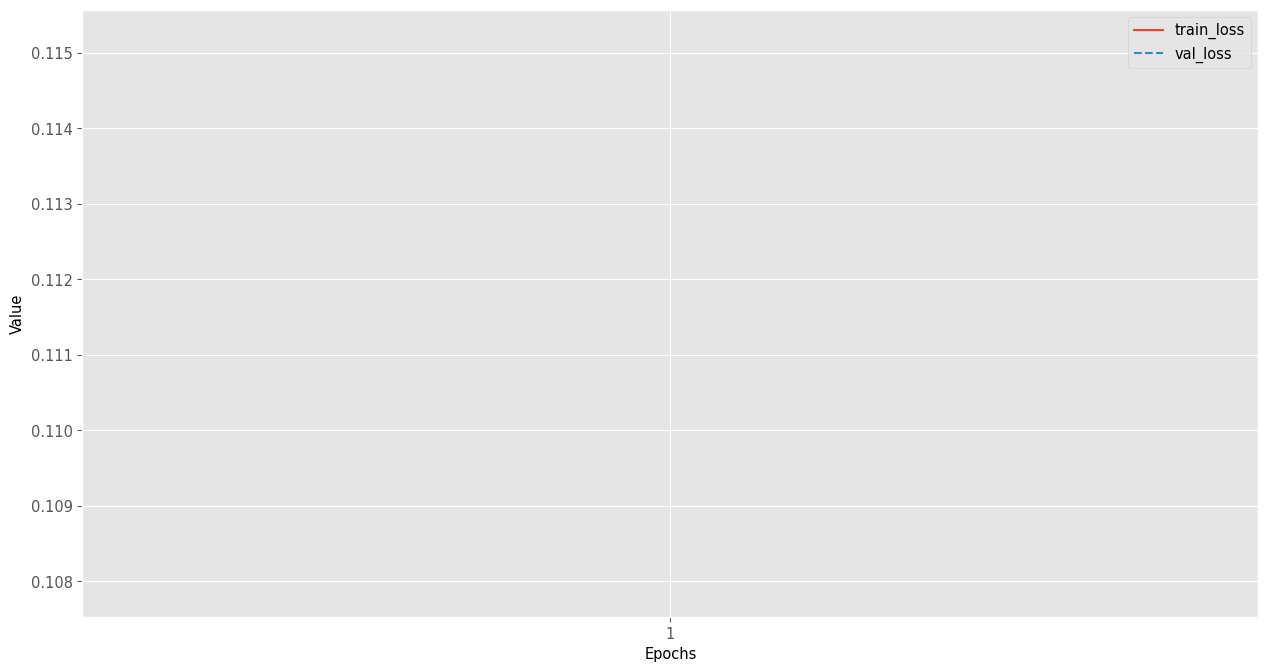

/usr/local/lib/python3.11/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


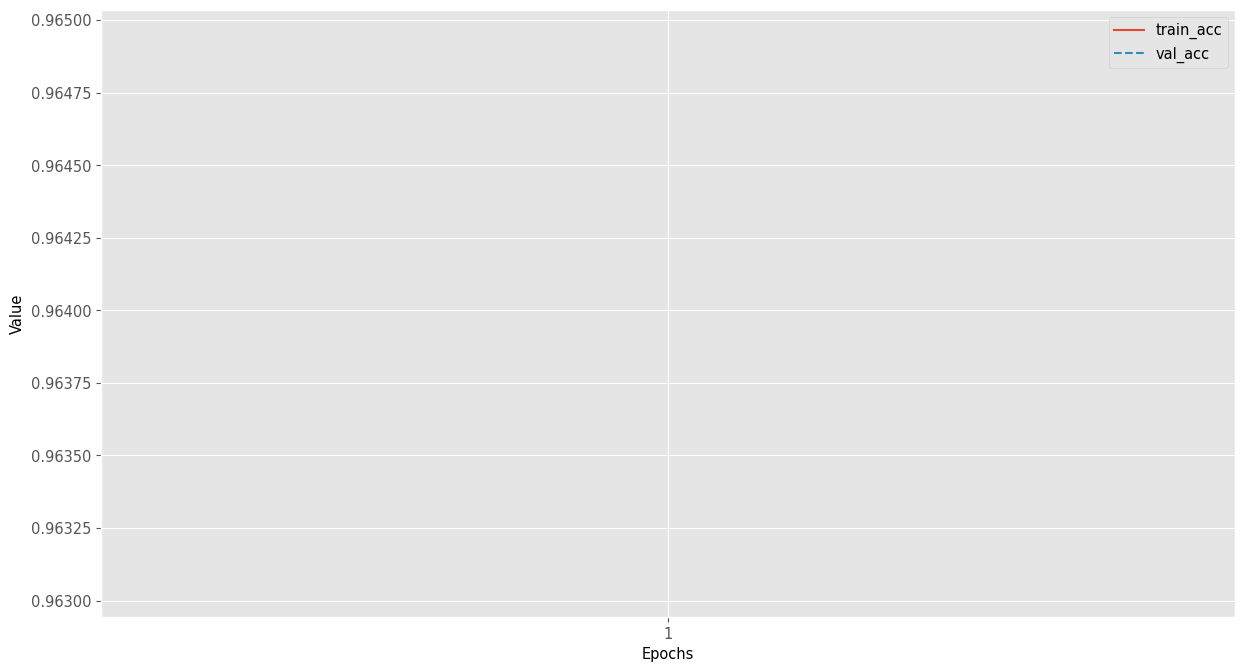

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )

# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

# Loop through each epoch.
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  # Perform one full pass over the training set.
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)

  # Get prediction form model on validation data.
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
  val_acc = accuracy_score(valid_labels, valid_predict)

  # Print loss and accuracy values to see how training evolves.
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()

  # Store the loss value for plotting the learning curve.
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)

# Plot loss curves.
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot accuracy curves.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

## Evaluate

The model correctly identifies ~60% of test examples with very few false positives. While this is not perfect, it might still be fairly useful.

  0%|          | 0/7104 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       False       0.97      0.99      0.98    420831
        True       0.86      0.63      0.73     33793

    accuracy                           0.96    454624
   macro avg       0.92      0.81      0.85    454624
weighted avg       0.96      0.96      0.96    454624



/usr/local/lib/python3.11/dist-packages/ml_things/plot_functions.py:676: DeprecationWarning: `magnify` needs to have value in [0,1]! `3` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


Normalized confusion matrix


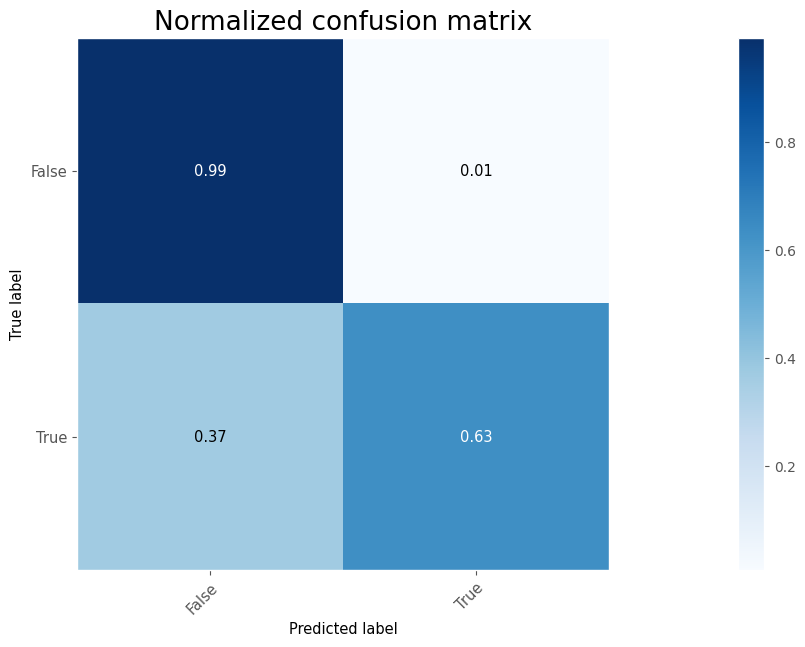

In [ ]:
# Get prediction form model on validation data. This is where you should use
# your test data.
true_labels, predictions_labels, avg_epoch_loss = validation(test_dataloader, device)

# Convert boolean keys to strings for target_names
target_names = [str(key) for key in labels_ids.keys()]

# Create the evaluation report.
evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=target_names)
# Show the evaluation report.
print(evaluation_report)

# Plot confusion matrix.
plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels,
                      classes=target_names, # Use target_names here as well
                      normalize=True,
                      magnify=3,
                      );

In [ ]:
# save model
model.save_pretrained('/content/drive/MyDrive/citing_sentence_classifier')
tokenizer.save_pretrained('/content/drive/MyDrive/citing_sentence_classifier')

In [ ]:
# example
citing_sentence = "We used the Adam optimizer."
non_citing_sentence = "We present a novel method for inverse square root calculation."

from transformers import pipeline

classifier = pipeline('text-classification',
                      model='/content/drive/MyDrive/citing_sentence_classifier')

citing_result = classifier(citing_sentence)
non_citing_result = classifier(non_citing_sentence)

print(citing_result)
print(non_citing_result)


Device set to use cuda:0


[{'label': 'LABEL_1', 'score': 0.5363579988479614}]
[{'label': 'LABEL_0', 'score': 0.9988425374031067}]
